In [2]:
from inputs import two_dimensional_peak
from neural_field import neural_field, gauss_kernel
import numpy as np
import matplotlib.pyplot as plt
import time

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

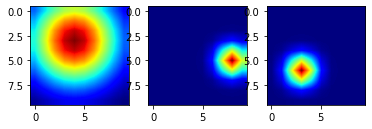

In [2]:
peak_3_4 = two_dimensional_peak(3,4,3,6.5, size=10)
peak_5_8 = two_dimensional_peak(5,8,1,1)
peak_6_3 = two_dimensional_peak(6,3,1,2)

plt.figure()

plt.subplot(1,3,1)
plt.imshow(peak_3_4, cmap='jet', interpolation='bilinear')
plt.subplot(1,3,2)
plt.imshow(peak_5_8, cmap='jet', interpolation='bilinear')
plt.subplot(1,3,3)
plt.imshow(peak_6_3, cmap='jet', interpolation='bilinear')

plt.show()

In [6]:
def absSigmoid(x, beta=1):
    return 0.5 * (1 + beta * x) / (1 + beta * np.abs(x))

def expSigmoid(x, beta):
    return 1 / (1 + np.exp(-beta * x))

**Different cedar sigmoids defined at cedar/auxiliaries/math/sigmoids.cpp**

* sigmoidAbs(x, beta, threshold): 
    0.5 * (1 + beta * (x - threshold) / (1 + beta * fabs(x - threshold)))
* sigmoidExp(x, beta, threshold):
    1 / (1 + exp(-beta * (x - threshold)))
* sigmoidHeaviside(x, threshold):
    if x < threshold 0; else 1
    
**Default size of neural fields: (50,50)**

**Variables needed for euler step:**
- matrix lateral_interaction (first retrieved by *this->mLateralInteraction->getData()*)
- matrix input_noise
- matrix neural_noise
- matrix u (from mActivation)
- matrix input_sum
- double h (from mRestingLevel)
- double tau
- double global_inhibition
- matrix sigmoid_u (first retrieved by *this->mSigmoidalActivation->getData()*)
- time (parameter of the function)

computations before neural field equation:
- sigmoid_u = _mSigmoid->getValue()->compute(u)  (only if mNoiseCorrelationKernal->getAmplitude = 0)
- lateral_interaction = this->\_mLateralKernelConvolution->convolve(sigmoid_u)

**Field equation in line 646, cedar/cedar/dynamics/fields/NeuralField.cpp:**  
*matrix d_u = -u + h + lateral_interaction + global_inhibition * cv.sum(sigmoid_u) + input_sum* 

**integrate one time step:**    
$u += \frac{time}{tau} * d_u + \frac{sqrt(time)}{tau} * \_mInputNoiseGain->getValue() * input\_noise$




- [x] add sigmoid_sum * global_inhibition (was probably the same before, either subtract global_inhibition in kernel every time or multiply it outside the kernel with the sigmoid_activation
- [x] adapt radius of ensembles (looks much better now, but values not really as expected)
- [x] make plots for different numbers of neurons
- [ ] make plots for different neural field sizes
- [ ] add different boundary conditions (currently only zeros) (only necessary if others are used in spatial reasoning model)
- [ ] add noise
- results different now --> what did i change? (might still be correct, max activation value is more similar to cedar max activation)
    - tau deleted
    - radius adapted (only between 2nd and 3rd try)
    - changed where c_glob calculation takes place?


400


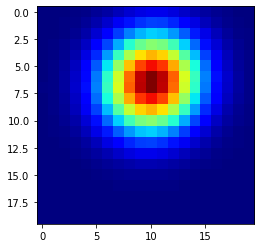

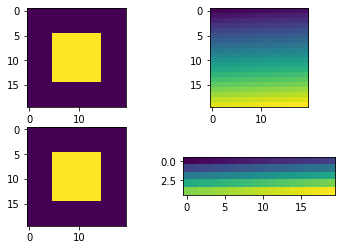

In [20]:
def gauss_kernel_fn(d, c, s):
    return c * np.exp(- d**2 / (2 * s**2)) 

c = 1
s = 3

sizes = [10,10]
kernel = np.zeros(np.product(np.array(sizes)*2))

kernel_sizes = np.array(sizes) * 2


for i in range(np.product(sizes)):
    x_pos = int(i / sizes[1] + sizes[0] /2) # position inside kernel, would be 
                                            # different value in activation matrix
    y_pos = int(i % sizes[1] + sizes[1] /2)
    kernel[x_pos*kernel_sizes[1] + y_pos] = 1
    cnt = 0
    j_movement = np.zeros(np.product(np.array(sizes)*2))
    for j in range(np.product(np.array(sizes)*2)):
        
        x_2_pos = int(j / kernel_sizes[1])
        y_2_pos = int(j % kernel_sizes[1])
        #print(j, ':', x_2_pos, y_2_pos)
        j_movement[j] = cnt
        cnt+=1
        
x_pos_kernel = 7
y_pos_kernel = 10
test_kernel = np.zeros(np.product(kernel_sizes))

for j in range(np.product(kernel_sizes)):
    x_2_pos_kernel = j / kernel_sizes[1]
    y_2_pos_kernel = j % kernel_sizes[1]
    #print('(%i,%i) (%i,%i)' %(x_pos_kernel, y_pos_kernel, x_2_pos_kernel, y_2_pos_kernel))
    
    d = np.sqrt((y_2_pos_kernel - y_pos_kernel)**2 + (x_2_pos_kernel - x_pos_kernel)**2)
    k = gauss_kernel_fn(d, c, s)
    test_kernel[j] = k
    
plt.figure()
plt.imshow(test_kernel.reshape(kernel_sizes), cmap='jet')
    

plt.figure()
plt.subplot(2,2,1)
plt.imshow(kernel.reshape(kernel_sizes))
plt.subplot(2,2,2)
plt.imshow(j_movement.reshape(kernel_sizes))
print(cnt)
plt.subplot(2,2,4)
plt.imshow(j_movement.reshape(kernel_sizes)[:5,:])

plt.subplot(2,2,3)
k = np.zeros(kernel_sizes)
k[int(sizes[0]/2):-int(sizes[0]/2), int(sizes[1]/2):-int(sizes[1]/2)] = 1
plt.imshow(k)

In [39]:
test_kernel.shape
mask = np.pad(np.ones((10,10)), pad_width=5, mode='constant')
# print(mask.astype(int).flatten())
mask = mask.astype(bool).flatten()
print(test_kernel.shape, test_kernel[mask].shape)
print(np.sum(test_kernel[mask]))
print(np.sum(test_kernel))

print()
print(test_kernel)
print()
print(test_kernel[mask])

(400,) (100,)
38.00136867063835
55.95170601034205

[2.54101243e-04 7.59027748e-04 2.02830349e-03 4.84878181e-03
 1.03694750e-02 1.98383392e-02 3.39530097e-02 5.19847145e-02
 7.12028650e-02 8.72456324e-02 9.56344448e-02 9.37798227e-02
 8.22676126e-02 6.45613794e-02 4.53253460e-02 2.84664870e-02
 1.59937772e-02 8.03882603e-03 3.61458663e-03 1.45394864e-03
 5.23195397e-04 1.55418256e-03 4.13013806e-03 9.81864429e-03
 2.08815583e-02 3.97281830e-02 6.76174706e-02 1.02954079e-01
 1.40233773e-01 1.70877978e-01 1.86270464e-01 1.81646199e-01
 1.58464890e-01 1.23669958e-01 8.63415407e-02 5.39261970e-02
 3.01303526e-02 1.50602803e-02 6.73420473e-03 2.69379161e-03
 9.63975726e-04 2.84768185e-03 7.52560220e-03 1.77916190e-02
 3.76282568e-02 7.11929764e-02 1.20499327e-01 1.82455312e-01
 2.47145567e-01 2.99483952e-01 3.24652467e-01 3.14838823e-01
 2.73138093e-01 2.11982830e-01 1.47178210e-01 9.14135912e-02
 5.07928339e-02 2.52475091e-02 1.12268792e-02 4.46605415e-03
 1.58932728e-03 4.66902245e-03 1.2

In [56]:
tmp = np.array([[1,2,3],[3,4,5],[5,6,7],[7,8,9]])
print(tmp)
print()
print(np.pad(tmp, pad_width=((2,2),(2,2)), mode='wrap'))

[[1 2 3]
 [3 4 5]
 [5 6 7]
 [7 8 9]]

[[6 7 5 6 7 5 6]
 [8 9 7 8 9 7 8]
 [2 3 1 2 3 1 2]
 [4 5 3 4 5 3 4]
 [6 7 5 6 7 5 6]
 [8 9 7 8 9 7 8]
 [2 3 1 2 3 1 2]
 [4 5 3 4 5 3 4]]


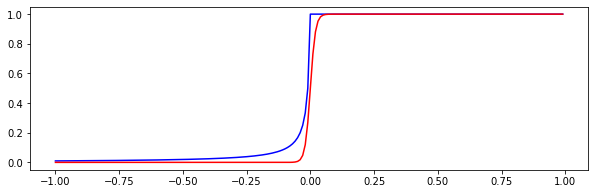

In [19]:
x = np.arange(-1,1, 0.01)
y_abs = absSigmoid(x, beta=100)
y_exp = expSigmoid(x, beta=100)

plt.figure(figsize=(10,3))
plt.plot(x, y_abs+0.5, 'blue')
plt.plot(x, y_exp, 'red')
plt.show()